In [1]:
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import arviz


In [2]:
def f(x):
    return torch.sin(20 * x) + 2 * torch.cos(14 * x) - 2 * torch.sin(6 * x)

In [3]:
X = torch.tensor([-1, -1/2, 0, 1/2, 1])
y = f(X)
y

In [5]:
kernel = gp.kernels.RBF(input_dim=1)
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10**(-4)))

In [ ]:
def model(x):
    gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
    loc, var = gpr(x, noiseless = False, full_cov = False)
    pyro.sample("loc", dist.Delta(loc))
    pyro.sample("var", dist.Delta(var))

In [8]:
C = 4
W = 100

In [9]:
nuts_kernel=pyro.infer.NUTS(gpr.model, jit_compile=True)
mcmc=pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=C, warmup_steps=W)
mcmc.run()

Warmup [1]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/600 [00:00, ?it/s]

c:\Users\Jacki\anaconda3\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
c:\Users\Jacki\anaconda3\lib\site-packages\torch\autograd\__init__.py:300: UserWarning: operator () profile_node %1383 : int[] = prim::profile_ivalue(%1381)
 does not have profile information (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\codegen\cuda\graph_fuser.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


c:\Users\Jacki\anaconda3\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


                     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.212  0.154     0.001      0.494      0.007    0.005   
kernel.variance     2.281  1.323     0.579      4.489      0.058    0.043   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     430.0     604.0   1.02  
kernel.variance        694.0     684.0   1.00  


array([<AxesSubplot:title={'center':'kernel.lengthscale'}>,
       <AxesSubplot:title={'center':'kernel.variance'}>], dtype=object)

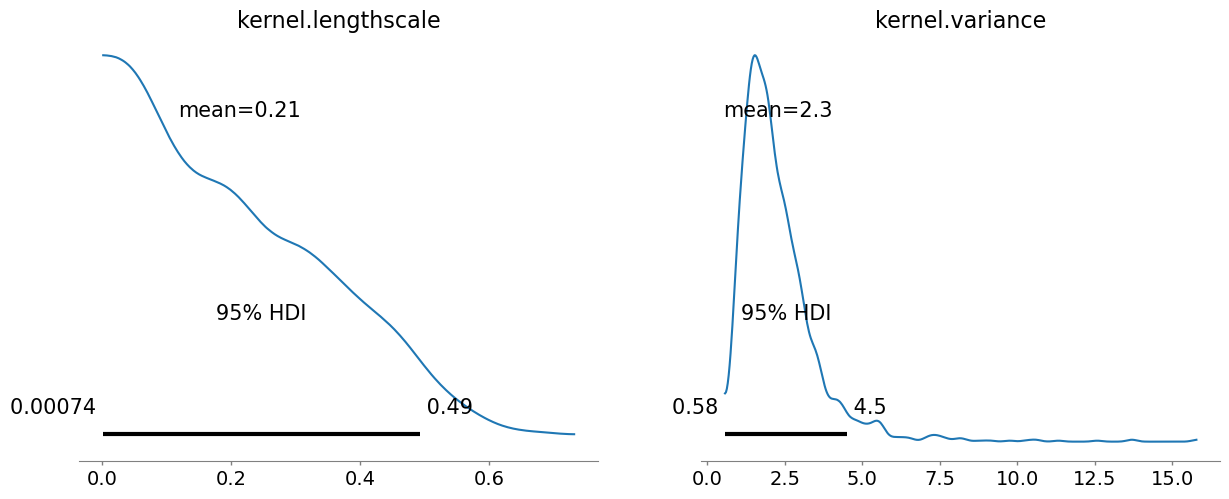

In [11]:
data = arviz.from_pyro(mcmc)
# Specify we want 95% credible interval (hdi=high density interval)
summary = arviz.summary(data, hdi_prob=0.95)
print(summary)
arviz.plot_posterior(data, hdi_prob=0.95)


In [ ]:
posterior_samples=mcmc.get_samples()

In [ ]:
x = torch.tensor([-1/4])

In [36]:
posterior_predictive = pyro.infer.Predictive(model, posterior_samples = posterior_samples)(x)


In [37]:
posterior_predictive

{'loc': tensor([[2.8028e+00],
         [2.8033e+00],
         [2.5389e+00],
         ...,
         [3.1041e-01],
         [8.0758e-06],
         [0.0000e+00]]),
 'var': tensor([[0.0886],
         [0.0753],
         [0.3390],
         ...,
         [1.4712],
         [2.4088],
         [1.5558]])}